### Imports

In [2]:
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib        as mpl
import os
import pandas as pd
import sys

import torch
import torch.nn          as nn
from torch.utils.data    import Dataset, DataLoader
from torch.optim         import Adam

from matplotlib          import rcParams, rc
rcParams.update({'figure.dpi': 200})
mpl.rcParams.update({'font.size': 8})
plt.rcParams['figure.dpi'] = 150


## import own functions
sys.path.insert(1, '/lhome/silkem/MACE/MACE/src/mace')
import autoencoder  as ae
import dataset      as ds
import plotting     as pl
import train_1Dchem     as tr

In [10]:
dirs = ds.get_dirs()

In [5]:
outpath = '/STER/silkem/ChemTorch/out/'
dir = '2023-08-31 11:54:16.857153'

input = np.load(outpath+'new/'+dir+'/input.npy')
p = input[0:-1]

print(input)
print(p)

[4.49234283e+04 2.49747452e+03 5.92562942e-02 3.64517630e+00
 2.07414140e+03]
[4.49234283e+04 2.49747452e+03 5.92562942e-02 3.64517630e+00]


In [13]:
a = [[1,2,3,4],[1,2,3,4]]
b = [[5,6,7,8],[5,6,7,8],[5,6,7,8]]
idx = np.array([0,len(a),len(b)])
i = 2

c = []
c.append(a)
c.append(b)

d = np.concatenate(c)

print(d)

start = idx[i-1]
stop = start + idx[i]

print(d[start:stop])
print(len(idx))

[[1 2 3 4]
 [1 2 3 4]
 [5 6 7 8]
 [5 6 7 8]
 [5 6 7 8]]
[[5 6 7 8]
 [5 6 7 8]
 [5 6 7 8]]
3


In [2]:
specs_file = '/lhome/silkem/MACE/MACE/data/rate16_IP_6000K_Crich_mean_Htot.specs'

idxs, mols = np.loadtxt(specs_file, usecols=(0,1), unpack = True, max_rows=466, skiprows=1, dtype='str')

molecs = dict()
for i in range(len(idxs)):
    molecs[mols[i]] = int(idxs[i])-1

### Torch settings

In [4]:
## Set up PyTorch 
cuda   = False
DEVICE = torch.device("cuda" if cuda else "cpu")
batch_size = 100
epochs = 40

kwargs = {'num_workers': 1, 'pin_memory': True} 

## Data

Dataset:
------------------------------
total # of samples: 2997
# training samples: 2097
# testing samples:  900
            ratio:  0.3

Plotting histrogram of dataset...


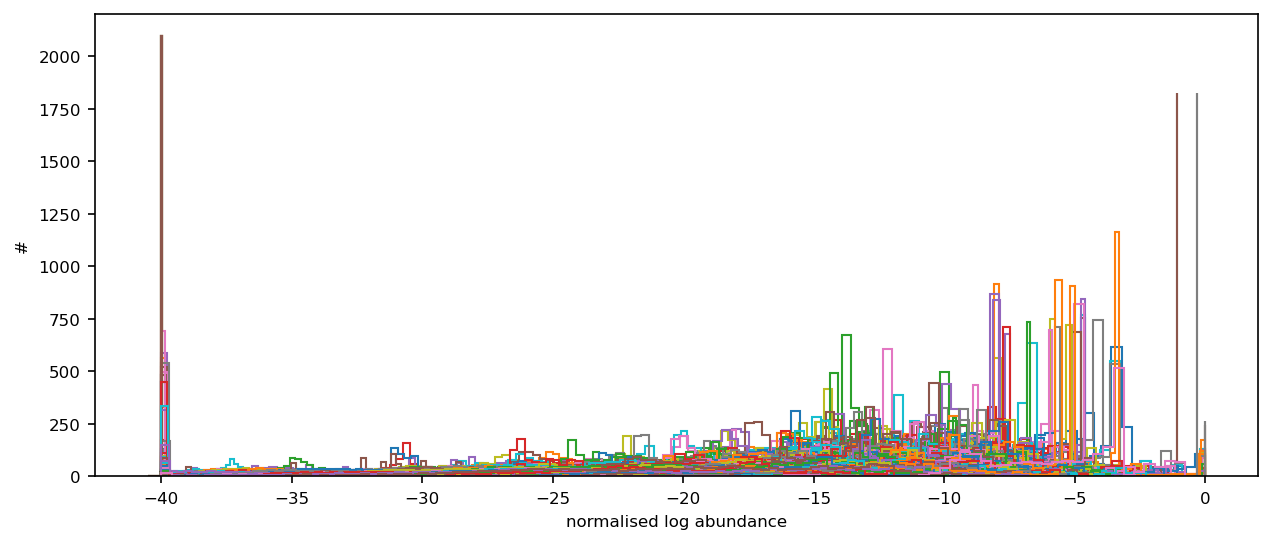

In [6]:
dir = '/lhome/silkem/MACE/MACE/data/train_data_C/'

train, data_loader, test_loader = ds.get_dataset(dir, batch_size, kwargs, plot = True, scale = None)


## Model 1

### hyperparameters

In [4]:
## Set up training hyperparams
lr = 1e-3                   ## learning rate

## Set up architecture hyperparams
input_dim  = train.df.shape[1]
hidden_dim = 300
latent_dim = 10
output_dim = input_dim
nb_hidden = 2
type = 'decr'

## Build model
model = ae.build(input_dim, hidden_dim, latent_dim,output_dim, nb_hidden, type, DEVICE)
ae.name(model, 'Encoder 1','Decoder 1','Model 1')
ae.overview(model)

NameError: name 'train' is not defined

### Training & testing

In [8]:
## Training & validating model

loss_train_all, loss_test_all = tr.Train(model, lr, data_loader, test_loader, epochs, DEVICE)
x_test, x_test_hat, loss = tr.Test(model, test_loader, DEVICE)


Model 1:
	Epoch 40 complete! 	Average loss train:  0.008553384115830773 	Average loss test:  0.010190228000283241
DONE!

loss Model 1:  0.010190228000283241


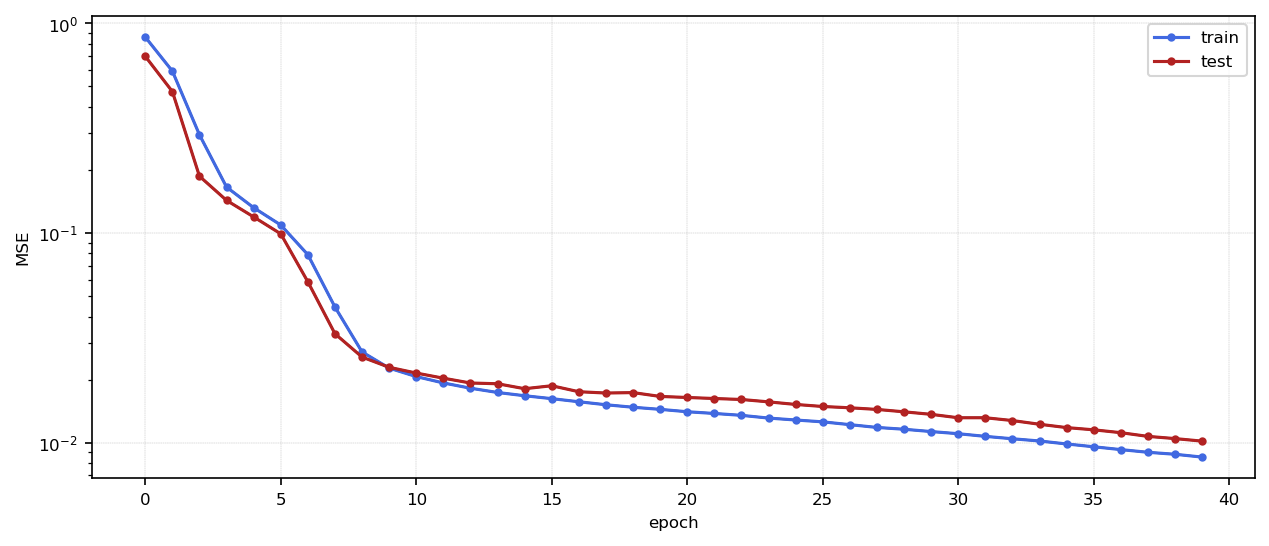

In [11]:
pl.plot_loss(loss_train_all, loss_test_all, log = True)

## Model 2 

### hyperparameters

In [11]:
## Set up training hyperparams
lr = 1e-3                   ## learning rate

## Set up architecture hyperparams
input_dim  = train.df.shape[1]
hidden_dim = 300
latent_dim = 10
output_dim = input_dim
nb_hidden = 2
type = 'decr'

## Build model
encoder = ae.Encoder( input_dim, hidden_dim, latent_dim, nb_hidden=nb_hidden, type = type)
encoder.set_name('Encoder 2')
decoder = ae.Decoder(latent_dim, hidden_dim, output_dim, nb_hidden=nb_hidden, type = type)
decoder.set_name('Decoder 2')
model2 = ae.Autoencoder(Encoder=encoder, Decoder=decoder).to(DEVICE)        # GPU/TPU/... --> XPU
model2.set_name('Model 2')

## Training & testing

In [12]:
## Training & validating model

loss_train_all2, loss_test_all2 = tr.Train(model2, lr, data_loader, test_loader, epochs, DEVICE)
x_test2, x_test_hat2, loss2 = tr.Test(model2, test_loader, DEVICE)


Model 2:
	Epoch 50 complete! 	Average loss train:  0.008509947563565913 	Average loss test:  0.010312010534107685
DONE!

loss Model 2:  0.010312010534107685


## Comparison of models

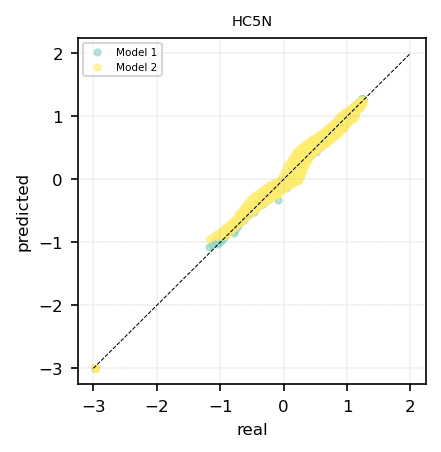

In [34]:
pl.plot_compare(x_test,[x_test_hat, x_test_hat2], [model, model2],molecs,'HC5N')


In [14]:
# pl.plot_hist(x_test)

In [1]:
pl.plot_hist(x_test_hat)

NameError: name 'pl' is not defined

In [14]:
dir_test = '/lhome/silkem/MACE/MACE/test_data/'

In [15]:
rad, real, pred = tr.test_abundance_profile(dir_test, 'test', model, DEVICE, kwargs, scale = 'norm')

In [18]:
rad, real, pred2 = tr.test_abundance_profile(dir_test, 'test', model2, DEVICE, kwargs, scale = 'norm')

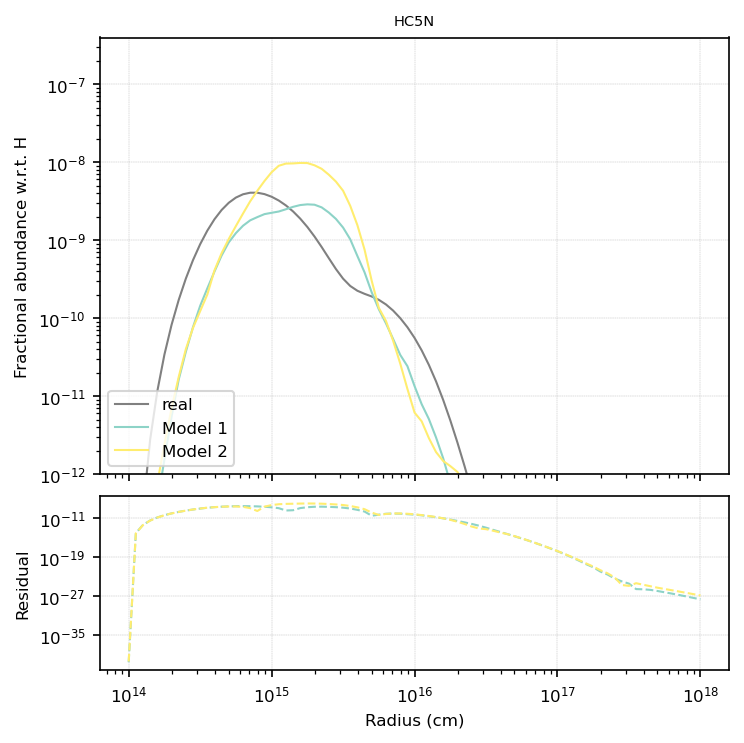

In [35]:
pl.plot_fracs_profile(rad, real, [pred, pred2], [model, model2], molecs, 'HC5N')